## DPC main

## 01. Prepare packages

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import numpy as np
import pandas as pd
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pickle
from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from torch.nn import ReLU

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
import torch.autograd.functional as F


from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

cuda is available


## 02. Load Policy & Tide

In [8]:
window = 10
P = 10
from dropout import enable_dropout 

def load_fcnn_model(setting_name, model_class, device="cpu"):
    import re
    # setting_name Ïòà: '5L_512H'
    match = re.match(r"(\d+)L_(\d+)H", setting_name)
    if match is None:
        raise ValueError(f"Invalid setting name format: {setting_name}")
    n_layers = int(match.group(1))
    hidden_dim = int(match.group(2))

    model = model_class(
        input_dim=6,
        output_dim=1,
        future_cov_dim=2,
        static_cov_dim=0, 
        input_chunk_length=window,
        output_chunk_length=P,
        hidden_dim=hidden_dim,
        n_layers=n_layers
    ).to(device)

    model.load_state_dict(torch.load(f"policy_model_moisezero_0.1_{setting_name}.pth", map_location=device))
    model.eval()
    enable_dropout(model) 
    return model

from Policy_copy import DPC_PolicyNN

setting_name = "5L_512H"
NNPolicy_basic = load_fcnn_model(setting_name, DPC_PolicyNN, device="cpu")




In [9]:
with open('nominal_params_w10_mid_noise_stable_final.pkl', 'rb') as file: 
    nominal_params = pickle.load(file)
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_mid_noise_stable_final.pth'))
nominal_TiDE.eval()
nominal_TiDE = nominal_TiDE.to(device)

## 03. Define Iteration

In [10]:
def NNPolicy_iteration(ref_future:torch.tensor, 
                x_past:torch.tensor, 
                u_past:torch.tensor, 
                c_fut:torch.tensor,
                NN_Nominal, 
):
    x_fut_in = ref_future
    past_cov = torch.cat([x_past.to(torch.float32), u_past.to(torch.float32)], dim=2)
    x_fut_in = x_fut_in.to(torch.float32)
    c_fut_in = c_fut.to(torch.float32)

    u_future_policy = NN_Nominal([past_cov,x_fut_in,c_fut_in,None]).squeeze(-1) 
    u_future_decision_policy = u_future_policy[:, 1, :].squeeze()

    return u_future_policy, u_future_decision_policy

## 04. Run Iteration

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def f_ss(x0, u):
    A = np.array([[0.3, 0.1], [0.1, 0.2]]) 
    B = np.array([[0.5], [1.0]])
    mu = np.array([[0], [0]]) * 0
    w = np.array([[0.0], [0.0]])
    x = A @ x0 + B * u + np.random.normal(mu, w, size=(2, 1))
    return x

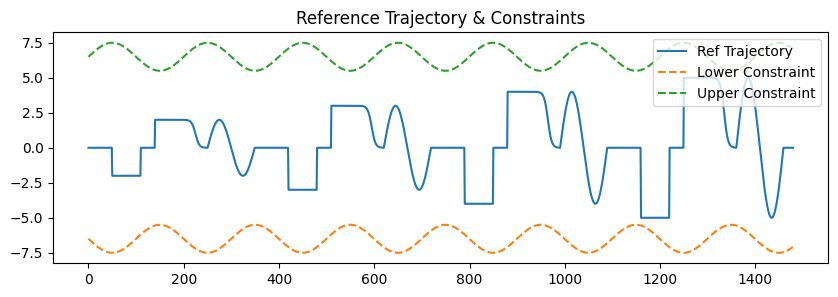

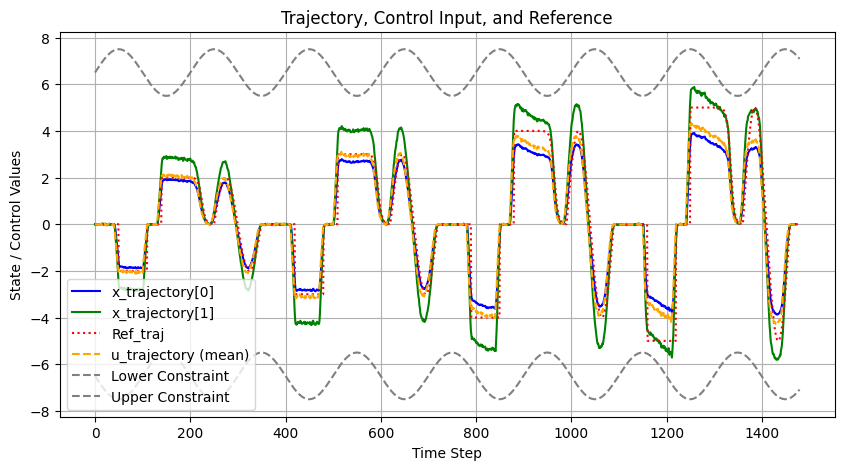

0.2929733689404453


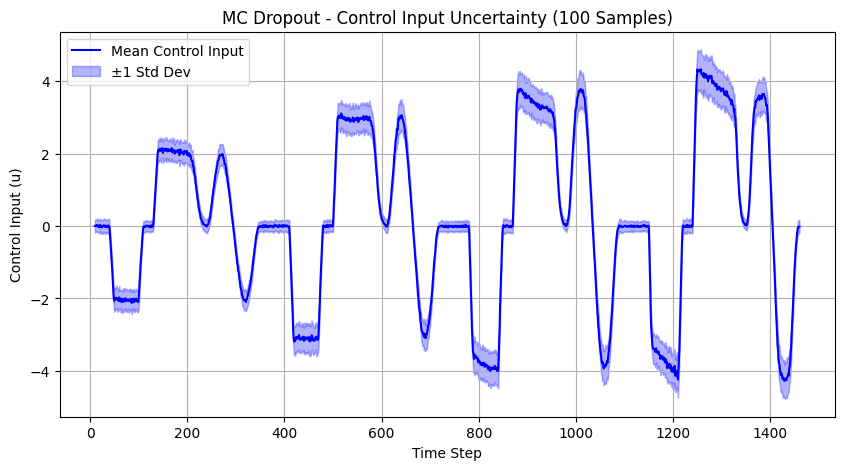

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1. Reference Trajectory Î∞è Constraint ÏÉùÏÑ±
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

# ÏÇ¨Ïù¥ÌÅ¥ ÌïòÎÇòÎ•º ÎßåÎìúÎäî Ìï®Ïàò
def make_cycle(scale):
    # 1) step sequence: [0, -s, -s, 0, s, s]Î•º 30Î≤à Î∞òÎ≥µ
    step_seq = torch.tensor(np.repeat([0, -scale, -scale, 0, scale, scale], 30))

    # 2) sigmoid sequence: 50Ìè¨Ïù∏Ìä∏
    def sigmoid(x):
        return 1 / (1 + np.exp(-x / 4))
    x_vals = np.linspace(0, 50, 50)
    sigmoid_seq = torch.tensor(-sigmoid(x_vals - 25) * scale + scale)

    # 3) sine sequence: 100Ìè¨Ïù∏Ìä∏
    x_sin = np.linspace(0, 2 * np.pi, 100)
    sine_seq = torch.tensor(scale * np.sin(x_sin))

    # 4) ÏïûÎí§ 20Ìè¨Ïù∏Ìä∏ Ï†úÎ°ú Ìå®Îî©
    zeros20 = torch.zeros(20)

    # ÏÇ¨Ïù¥ÌÅ¥ Íµ¨ÏÑ±
    return torch.cat((zeros20, step_seq, sigmoid_seq, sine_seq, zeros20))


# Ïä§ÏºÄÏùº Î¶¨Ïä§Ìä∏
scales = [2, 3, 4, 5]

# ÎÑ§ ÏÇ¨Ïù¥ÌÅ¥ÏùÑ Ïù¥Ïñ¥Î∂ôÏûÑ
cycles = [make_cycle(s) for s in scales]
Ref_traj = torch.cat(cycles)

# Ï†ÑÏ≤¥ Í∏∏Ïù¥
tot_step = len(Ref_traj)


# Ï†úÏïΩ Í∂§Ï†Å ÏÉùÏÑ±
x_constraint = np.linspace(0, tot_step, tot_step)
C_Ref_traj_up = torch.tensor(
    6.5 + 1 * np.sin(2 * np.pi * x_constraint / 200)
)
C_Ref_traj_low = -C_Ref_traj_up

plt.figure(figsize=(10, 3))
plt.plot(Ref_traj.numpy(), label="Ref Trajectory", linestyle='-')
plt.plot(C_Ref_traj_low.numpy(), label="Lower Constraint", linestyle='--')
plt.plot(C_Ref_traj_up.numpy(), label="Upper Constraint", linestyle='--')
plt.legend(loc="upper right")
plt.title("Reference Trajectory & Constraints")
plt.show()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 2. Normalization Î∞è Sliding Window Ï§ÄÎπÑ
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
window = 10
p = 10

# Normalization factors
x1_diff = 9.32425809 
x2_diff = 14.13760952
u_diff  = 9.992800291743697 

Ref_traj = Ref_traj / (x1_diff / 2)
C_Ref_traj_low = C_Ref_traj_low / (x2_diff / 2)
C_Ref_traj_up  = C_Ref_traj_up  / (x2_diff / 2)

sliding_data_ref_x1   = Ref_traj.unfold(0, window, 1)
sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
sliding_data_con_x2_up  = C_Ref_traj_up.unfold(0, window, 1)
sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

num_steps = len(Ref_traj) - window + 1

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 3. ÏãúÎÆ¨Î†àÏù¥ÏÖò Ï¥àÍ∏∞Ìôî Î∞è Monte Carlo Dropout ÏàòÌñâ
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# state trajectory: [num_steps, 2], control trajectory: [num_steps, 1]
x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

# MC Dropout Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏ (Í∞Å Ïä§ÌÖùÎßàÎã§ Ï†úÏñ¥ ÏûÖÎ†•Ïùò ÌèâÍ∑†Í≥º ÌëúÏ§ÄÌé∏Ï∞®)
mean_u_list = []
std_u_list = []

# Monte Carlo Dropout ÏãúÌñâ ÌöüÏàò
mc_samples = 100

# (Ï∞∏Í≥†: ÏïÑÎûò forÎ¨∏ÏóêÏÑúÎäî NNPolicy_iteration, f_ss, Í∑∏Î¶¨Í≥† NNPolicy_basicÏù¥ Ïù¥ÎØ∏ Ï†ïÏùòÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.)

for i in range(num_steps - 20):
    # Ï§ÄÎπÑ: Í≥ºÍ±∞ state, Í≥ºÍ±∞ Ï†úÏñ¥ ÏûÖÎ†•, ÌòÑÏû¨ Ï∞∏Ï°∞, future constraint Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    x_past_policy = x_trajectory[i:i+window, :].unsqueeze(0)    # shape: [1, window, 2]
    u_past_policy = u_trajectory[i:i+window, :].unsqueeze(0)      # shape: [1, window, 1]
    x_ref_policy  = torch.tensor(sliding_data_ref_x1[i+window]).unsqueeze(0)  # shape: [1, window]
    c_fut_policy  = torch.tensor(sliding_data_con_x2[i+window]).unsqueeze(0)   # shape: [1, window, 2]
    
    # Monte Carlo Dropout: NNPolicy_iterationÏùÑ 100Ìöå ÏãúÌñâÌïòÍ≥† Ï†úÏñ¥ ÏûÖÎ†• (u_decision)ÏùÑ ÏàòÏßë
    mc_u_samples = []
    for _ in range(mc_samples):
        # NNPolicy_iterationÏùÄ (u_future_policy, u_future_decision_policy)Î•º Î∞òÌôòÌïúÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
        _, u_decision = NNPolicy_iteration(x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic)
        mc_u_samples.append(u_decision.item())
    mc_u_samples = np.array(mc_u_samples)
    mean_u = mc_u_samples.mean()
    std_u  = mc_u_samples.std()
    
    # MC Dropout Í≤∞Í≥º Ï†ÄÏû•
    mean_u_list.append(mean_u)
    std_u_list.append(std_u)
    
    # MC ÌèâÍ∑† Ï†úÏñ¥ ÏûÖÎ†•ÏùÑ u_trajectoryÏóê Í∏∞Î°ù (ÌòÑÏû¨ Ïä§ÌÖù i+window)
    u_trajectory[i+window] = mean_u

    # ÏÉÅÌÉú ÏóÖÎç∞Ïù¥Ìä∏: ÌòÑÏû¨ stateÏôÄ Ï†úÏñ¥ ÏûÖÎ†•ÏùÑ Ïù¥Ïö©Ìï¥ Îã§Ïùå state Í≥ÑÏÇ∞ (f_ss Ìï®Ïàò ÏÇ¨Ïö©)
    # ÌòÑÏû¨ stateÏôÄ u_decisionÏùò ÌèâÍ∑†Í∞íÏùÑ ÏÇ¨Ïö© (Ï†ïÍ∑úÌôîÎêú Í∞íÏûÑ)
    x_f = x_trajectory[i+window, :].unsqueeze(-1)  # shape: [2, 1]
    # ÌèâÍ∑† Ï†úÏñ¥ ÏûÖÎ†•ÏúºÎ°ú tensor ÏÉùÏÑ± (Ï†ïÍ∑úÌôî ÏÉÅÌÉú)
    u_f = torch.tensor([[mean_u]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 1]
    
    # Denormalize x_f, u_f for simulation: (Í∞ÅÍ∞Å Í≥±Ìï¥Ï§å)
    x_f_denorm = x_f.clone()
    u_f_denorm = u_f.clone()
    x_f_denorm[0] = x_f_denorm[0] * (x1_diff / 2)
    x_f_denorm[1] = x_f_denorm[1] * (x2_diff / 2)
    u_f_denorm[0] = u_f_denorm[0] * (u_diff / 2)
    
    # f_ss Ìï®Ïàò: Denormalized stateÏôÄ Ï†úÏñ¥ ÏûÖÎ†•ÏùÑ Î∞õÏïÑ Îã§Ïùå stateÎ•º Î∞òÌôòÌïúÎã§Í≥† Í∞ÄÏ†ï
    x_f_np = x_f_denorm.detach().cpu().numpy()
    u_f_np = u_f_denorm.detach().cpu().numpy()
    x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32)
    
    # Normalize x_next ÌõÑ, state trajectoryÏóê Í∏∞Î°ù

    val0 = x_next[0, 0, 0] / (x1_diff / 2)
    val1 = x_next[0, 0, 1] / (x2_diff / 2)
    x_next_extracted = torch.tensor([val0, val1], dtype=torch.float32)

    x_trajectory[i+window+1, :] = x_next_extracted

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 4. Denormalize Î∞è Í≤∞Í≥º ÏãúÍ∞ÅÌôî
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
x_trajectory[:, 0] = x_trajectory[:, 0] * (x1_diff / 2)  
x_trajectory[:, 1] = x_trajectory[:, 1] * (x2_diff / 2)  
u_trajectory[:, 0] = u_trajectory[:, 0] * (u_diff / 2)  
Ref_traj_plot = Ref_traj * (x1_diff / 2)
C_Ref_traj_low_plot = C_Ref_traj_low * (x2_diff / 2)
C_Ref_traj_up_plot = C_Ref_traj_up * (x2_diff / 2)

# ÌîåÎ°Ø 1: x_trajectory, Reference, Constraint Îì±
plt.figure(figsize=(10, 5))
plt.plot(x_trajectory[:, 0].detach().cpu().numpy(), label="x_trajectory[0]", color="b")
plt.plot(x_trajectory[:, 1].detach().cpu().numpy(), label="x_trajectory[1]", color="g")
plt.plot(Ref_traj_plot.detach().cpu().numpy(), label="Ref_traj", color="r", linestyle="dotted")
plt.plot(u_trajectory[:, 0].detach().cpu().numpy(), label="u_trajectory (mean)", color="orange", linestyle="dashed")
plt.plot(C_Ref_traj_low_plot.detach().cpu().numpy(), label="Lower Constraint", color="gray", linestyle="dashed")
plt.plot(C_Ref_traj_up_plot.detach().cpu().numpy(), label="Upper Constraint", color="gray", linestyle="dashed")
plt.xlabel("Time Step")
plt.ylabel("State / Control Values")
plt.legend(loc="best")
plt.grid()
plt.title("Trajectory, Control Input, and Reference")
plt.show()

time_axis = np.arange(window, window + len(mean_u_list))
mean_u_array = np.array(mean_u_list) * (u_diff / 2)  # denormalize
std_u_array  = np.array(std_u_list) * (u_diff / 2)       # denormalize


print(std_u_array.mean())

plt.figure(figsize=(10, 5))
plt.plot(time_axis, mean_u_array, label="Mean Control Input", color="blue")
plt.fill_between(time_axis, mean_u_array - 1*std_u_array, mean_u_array + 1*std_u_array,
                 color="blue", alpha=0.3, label="¬±1 Std Dev")
plt.xlabel("Time Step")
plt.ylabel("Control Input (u)")
plt.title("MC Dropout - Control Input Uncertainty (100 Samples)")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
window = 10
P = 10
from dropout import enable_dropout 

def load_fcnn_model(setting_name, model_class, device="cpu"):
    import re
    # setting_name Ïòà: '5L_512H'
    match = re.match(r"(\d+)L_(\d+)H", setting_name)
    if match is None:
        raise ValueError(f"Invalid setting name format: {setting_name}")
    n_layers = int(match.group(1))
    hidden_dim = int(match.group(2))

    model = model_class(
        input_dim=6,
        output_dim=1,
        future_cov_dim=2,
        static_cov_dim=0, 
        input_chunk_length=window,
        output_chunk_length=P,
        hidden_dim=hidden_dim,
        n_layers=n_layers
    ).to(device)

    model.load_state_dict(torch.load(f"policy_model_moisezero_0.1_{setting_name}.pth", map_location=device))
    model.eval()
    return model

from Policy_copy import DPC_PolicyNN

setting_name = "5L_512H"
NNPolicy_basic = load_fcnn_model(setting_name, DPC_PolicyNN, device="cpu")




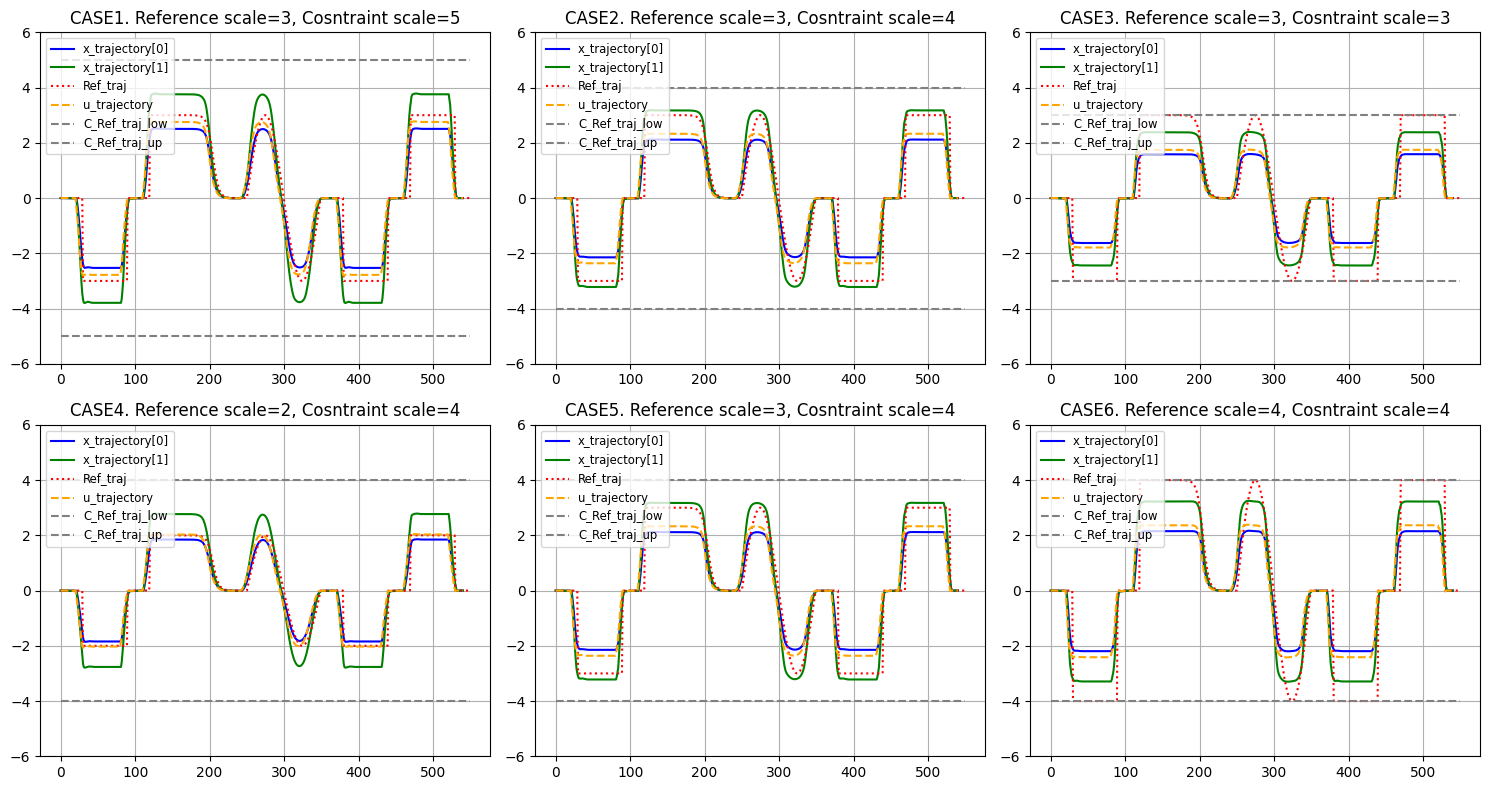

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt



def run_simulation(scale, c_scale):
    Ref_traj_step = torch.tensor(np.repeat(np.array([0, -scale, -scale, 0, scale, scale]), 30))

    def sigmoid(x):
        return 1 / (1 + np.exp(-x / 4))

    x = np.linspace(0, 50, 50)
    y = -sigmoid(x - 25) * scale + scale
    Ref_traj_sigmoid = torch.tensor(y)

    x_sin = np.linspace(0, 2 * np.pi, 100)
    y_sin = scale * np.sin(x_sin)
    Ref_traj_sin = torch.tensor(y_sin)

    Ref_traj = torch.cat((Ref_traj_step, Ref_traj_sigmoid, torch.zeros(20), Ref_traj_sin, Ref_traj_step, torch.zeros(20)))
    tot_step = len(Ref_traj)

    C_Ref_traj_low = torch.tensor(np.repeat(np.array([-c_scale]), tot_step))
    C_Ref_traj_up = torch.tensor(np.repeat(np.array([c_scale]), tot_step))

    x1_diff = 9.32425809
    x2_diff = 14.13760952
    u_diff = 9.992800291743697
    window = 10

    Ref_traj = Ref_traj / (x1_diff / 2)
    C_Ref_traj_low = C_Ref_traj_low / (x2_diff / 2)
    C_Ref_traj_up = C_Ref_traj_up / (x2_diff / 2)

    sliding_data_ref_x1 = Ref_traj.unfold(0, window, 1)
    sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
    sliding_data_con_x2_up = C_Ref_traj_up.unfold(0, window, 1)
    sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

    num_steps = len(Ref_traj) - window + 1

    x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
    u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

    for i in range(num_steps - 20):
        x_past_policy = x_trajectory[i:i + window, :].unsqueeze(0)
        u_past_policy = u_trajectory[i:i + window, :].unsqueeze(0)
        x_ref_policy = torch.tensor(sliding_data_ref_x1[i + window]).unsqueeze(0)
        c_fut_policy = torch.tensor(sliding_data_con_x2[i + window]).unsqueeze(0)

        u_future_policy, u_future_decision_policy = NNPolicy_iteration(
            x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic
        )

        u_trajectory[i + window] = u_future_decision_policy.squeeze()

        x_f = x_trajectory[i + window, :].unsqueeze(-1)
        u_f = u_future_decision_policy.unsqueeze(0).unsqueeze(0)

        x_f_denorm = x_f.clone()
        u_f_denorm = u_f.clone()
        x_f_denorm[0] = x_f_denorm[0] * (x1_diff / 2)
        x_f_denorm[1] = x_f_denorm[1] * (x2_diff / 2)
        u_f_denorm[0] = u_f_denorm[0] * (u_diff / 2)

        x_f_np = x_f_denorm.detach().cpu().numpy()
        u_f_np = u_f_denorm.detach().cpu().numpy()
        x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32).squeeze(-1)

        x_next[0] = x_next[0] / (x1_diff / 2)
        x_next[1] = x_next[1] / (x2_diff / 2)

        x_trajectory[i + window + 1, :] = x_next

    x_trajectory[:, 0] *= x1_diff / 2
    x_trajectory[:, 1] *= x2_diff / 2
    u_trajectory[:, 0] *= u_diff / 2
    Ref_traj *= x1_diff / 2
    C_Ref_traj_low *= x2_diff / 2
    C_Ref_traj_up *= x2_diff / 2

    return x_trajectory, u_trajectory, Ref_traj, C_Ref_traj_low, C_Ref_traj_up

test_cases = [
    (3, 5), (3, 4), (3, 3),  
    (2, 4), (3, 4), (4, 4) 
]

titles = [
    "CASE1. Reference scale=3, Cosntraint scale=5", "CASE2. Reference scale=3, Cosntraint scale=4", "CASE3. Reference scale=3, Cosntraint scale=3",
    "CASE4. Reference scale=2, Cosntraint scale=4", "CASE5. Reference scale=3, Cosntraint scale=4", "CASE6. Reference scale=4, Cosntraint scale=4"
]

results = [run_simulation(scale, c_scale) for scale, c_scale in test_cases]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (x_trajectory, u_trajectory, Ref_traj, C_Ref_traj_low, C_Ref_traj_up) in enumerate(results):
    ax = axes[i]
    ax.plot(x_trajectory[:, 0].detach().cpu().numpy(), label="x_trajectory[0]", color="b")
    ax.plot(x_trajectory[:, 1].detach().cpu().numpy(), label="x_trajectory[1]", color="g")
    ax.plot(Ref_traj.detach().cpu().numpy(), label="Ref_traj", color="r", linestyle="dotted")
    ax.plot(u_trajectory[:, 0].detach().cpu().numpy(), label="u_trajectory", color="orange", linestyle="dashed")
    ax.plot(C_Ref_traj_low.detach().cpu().numpy(), label="C_Ref_traj_low", color="gray", linestyle="dashed")
    ax.plot(C_Ref_traj_up.detach().cpu().numpy(), label="C_Ref_traj_up", color="gray", linestyle="dashed")
    ax.set_title(titles[i])
    ax.legend(loc="upper left", fontsize="small")
    ax.grid()
    ax.set_ylim(-6, 6)

plt.tight_layout()
plt.show()


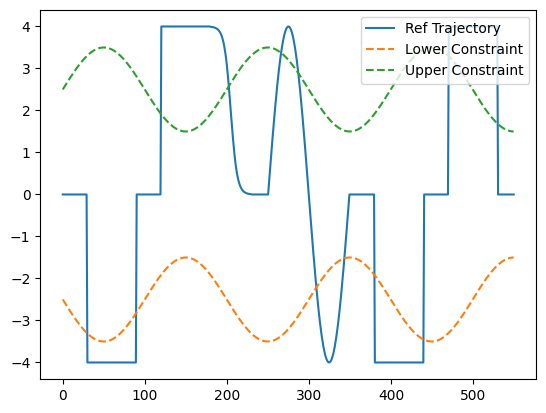

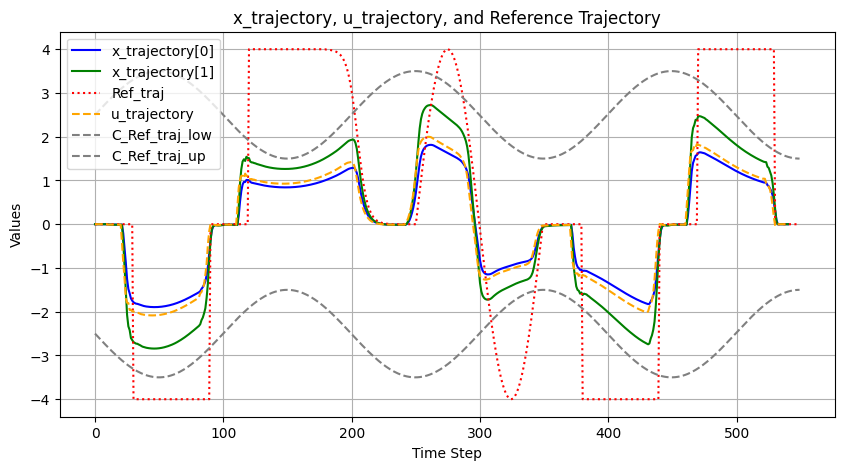

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

scaling = 4
Ref_traj_step = torch.tensor(np.repeat(np.array([0, -scaling, -scaling, 0, scaling, scaling]), 30))
def sigmoid(x):
    return 1 / (1 + np.exp(-x / 4))

a = scaling
x = np.linspace(0, 50, 50)
y = -sigmoid(x - 25) * a + scaling
Ref_traj_sigmoid = torch.tensor(y)

x_sin = np.linspace(0, 2 * np.pi, 100)  
y_sin = scaling * np.sin(x_sin) 
Ref_traj_sin = torch.tensor(y_sin)

Ref_traj = torch.cat((Ref_traj_step, Ref_traj_sigmoid, torch.zeros(20), Ref_traj_sin, Ref_traj_step, torch.zeros(20)))
tot_step = len(Ref_traj)

x_constraint = np.linspace(0, tot_step, tot_step)
C_Ref_traj_up = torch.tensor(2.5 + 1 * np.sin(2 * np.pi * x_constraint / 200))
C_Ref_traj_low = -C_Ref_traj_up  


plt.plot(Ref_traj.numpy(), label="Ref Trajectory", linestyle='-')
plt.plot(C_Ref_traj_low.numpy(), label="Lower Constraint", linestyle='--')
plt.plot(C_Ref_traj_up.numpy(), label="Upper Constraint", linestyle='--')

plt.legend(loc = "upper right")
plt.show()

window = 10
p = 10
tot_window = len(Ref_traj)

x1_diff = 9.32425809 
x2_diff = 14.13760952
u_diff = 9.992800291743697 
Ref_traj = Ref_traj/ (x1_diff/2)
C_Ref_traj_low = C_Ref_traj_low / (x2_diff/2)
C_Ref_traj_up = C_Ref_traj_up / (x2_diff/2)

sliding_data_ref_x1 = Ref_traj.unfold(0, window, 1)
sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
sliding_data_con_x2_up = C_Ref_traj_up.unfold(0, window, 1)
sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

num_steps = len(Ref_traj)-window+1

import torch

x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

for i in range(num_steps - 20):

    x_past_policy = x_trajectory[i:i+window, :].unsqueeze(0)  
    u_past_policy = u_trajectory[i:i+window, :].unsqueeze(0) 

    x_ref_policy = torch.tensor(sliding_data_ref_x1[i+window]).unsqueeze(0)

    c_fut_policy = torch.tensor(sliding_data_con_x2[i+window]).unsqueeze(0)  
    u_future_policy, u_future_decision_policy = NNPolicy_iteration(
        x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic
    )

    u_trajectory[i+window] = u_future_decision_policy.squeeze()
    x_f = x_trajectory[i+window, :].unsqueeze(-1)
    u_f = u_future_decision_policy.unsqueeze(0).unsqueeze(0)

    x_f_denorm = x_f.clone() 
    u_f_denorm = u_f.clone() 

    x_f_denorm[0] = x_f_denorm[0] * (x1_diff / 2)
    x_f_denorm[1] = x_f_denorm[1] * (x2_diff / 2)
    u_f_denorm[0] = u_f_denorm[0] * (u_diff / 2)

    x_f_np = x_f_denorm.detach().cpu().numpy() 
    u_f_np = u_f_denorm.detach().cpu().numpy()  
    x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32).squeeze(-1)
    
    x_next[0] = x_next[0] / (x1_diff / 2)
    x_next[1] = x_next[1] / (x2_diff / 2)
    x_trajectory[i+window+1, :] = x_next  


x_trajectory[:, 0] = x_trajectory[:, 0] * (x1_diff / 2)  
x_trajectory[:, 1] = x_trajectory[:, 1] * (x2_diff / 2)  
u_trajectory[:, 0] = u_trajectory[:, 0] * (u_diff / 2)  
Ref_traj = Ref_traj * (x1_diff / 2) 
C_Ref_traj_low = C_Ref_traj_low * (x2_diff / 2) 
C_Ref_traj_up = C_Ref_traj_up * (x2_diff / 2)  

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(x_trajectory[:, 0].detach().cpu().numpy(), label="x_trajectory[0]", color="b")
plt.plot(x_trajectory[:, 1].detach().cpu().numpy(), label="x_trajectory[1]", color="g")

plt.plot(Ref_traj.detach().cpu().numpy(), label="Ref_traj", color="r", linestyle="dotted")
plt.plot(u_trajectory[:, 0].detach().cpu().numpy(), label="u_trajectory", color="orange", linestyle="dashed")
plt.plot(C_Ref_traj_low.detach().cpu().numpy(), label="C_Ref_traj_low", color="gray", linestyle="dashed")
plt.plot(C_Ref_traj_up.detach().cpu().numpy(), label="C_Ref_traj_up", color="gray", linestyle="dashed")

plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend(loc="best")
plt.grid()
plt.title("x_trajectory, u_trajectory, and Reference Trajectory")
plt.show()



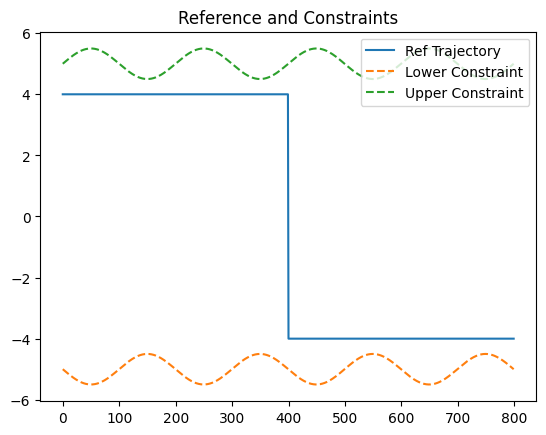

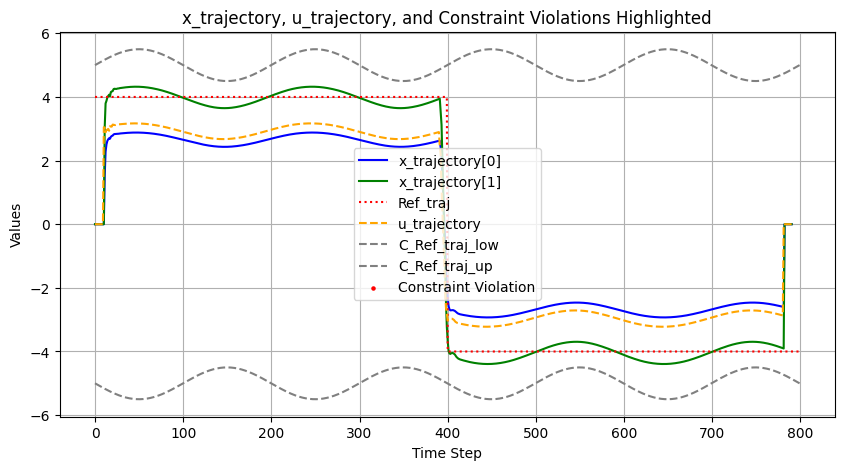

üîç Total decision steps: 791
‚ùå Constraint violation steps: 0
üìâ Violation rate: 0.00%

üìè Loss measured from step 100 to 700
üìå Tracking Loss      : 1.3947
üìå Smoothness Loss    : 0.0086
üìå Constraint Loss    : 0.0000
‚úÖ Total Loss         : 1.4033

üìè Constraint RMSE (x2 vs nearest boundary) from step 100 to 700
üìå Constraint Distance RMSE : 1.0412


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1. Reference Trajectory ÏÑ§Ï†ï
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
scaling = 4
total_steps = 800

# Step trajectory: Ïïû 400ÏùÄ +4, Îí§ 400ÏùÄ -4
Ref_traj = torch.ones(total_steps) * (-scaling)
Ref_traj[:400] = scaling

# Constraint (sin) Ìïú Ï£ºÍ∏∞ Í∏∏Ïù¥ = 200
x_constraint = np.linspace(0, total_steps, total_steps)
C_Ref_traj_up = torch.tensor(5 + 0.5 * np.sin(2 * np.pi * x_constraint / 200))
C_Ref_traj_low = -C_Ref_traj_up

# Plot
plt.plot(Ref_traj.numpy(), label="Ref Trajectory", linestyle='-')
plt.plot(C_Ref_traj_low.numpy(), label="Lower Constraint", linestyle='--')
plt.plot(C_Ref_traj_up.numpy(), label="Upper Constraint", linestyle='--')
plt.legend(loc="upper right")
plt.title("Reference and Constraints")
plt.show()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 2. Normalization & Sliding
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
window = 10
p = 10

x1_diff = 9.32425809
x2_diff = 14.13760952
u_diff = 9.992800291743697

Ref_traj = Ref_traj / (x1_diff / 2)
C_Ref_traj_low = C_Ref_traj_low / (x2_diff / 2)
C_Ref_traj_up = C_Ref_traj_up / (x2_diff / 2)

sliding_data_ref_x1 = Ref_traj.unfold(0, window, 1)
sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
sliding_data_con_x2_up = C_Ref_traj_up.unfold(0, window, 1)
sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

num_steps = len(Ref_traj) - window + 1

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 3. ÏãúÎÆ¨Î†àÏù¥ÏÖò
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

for i in range(num_steps - 20):
    x_past_policy = x_trajectory[i:i+window, :].unsqueeze(0)
    u_past_policy = u_trajectory[i:i+window, :].unsqueeze(0)
    x_ref_policy = torch.tensor(sliding_data_ref_x1[i+window]).unsqueeze(0)
    c_fut_policy = torch.tensor(sliding_data_con_x2[i+window]).unsqueeze(0)

    u_future_policy, u_future_decision_policy = NNPolicy_iteration(
        x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic
    )

    u_trajectory[i+window] = u_future_decision_policy.squeeze()
    x_f = x_trajectory[i+window, :].unsqueeze(-1)
    u_f = u_future_decision_policy.unsqueeze(0).unsqueeze(0)

    x_f_denorm = x_f.clone()
    u_f_denorm = u_f.clone()
    x_f_denorm[0] = x_f_denorm[0] * (x1_diff / 2)
    x_f_denorm[1] = x_f_denorm[1] * (x2_diff / 2)
    u_f_denorm[0] = u_f_denorm[0] * (u_diff / 2)

    x_f_np = x_f_denorm.detach().cpu().numpy()
    u_f_np = u_f_denorm.detach().cpu().numpy()
    x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32).squeeze(-1)

    x_next[0] = x_next[0] / (x1_diff / 2)
    x_next[1] = x_next[1] / (x2_diff / 2)
    x_trajectory[i+window+1, :] = x_next

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 4. Ïó≠Ï†ïÍ∑úÌôî & ÏãúÍ∞ÅÌôî
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
x_trajectory[:, 0] = x_trajectory[:, 0] * (x1_diff / 2)
x_trajectory[:, 1] = x_trajectory[:, 1] * (x2_diff / 2)
u_trajectory[:, 0] = u_trajectory[:, 0] * (u_diff / 2)
Ref_traj = Ref_traj * (x1_diff / 2)
C_Ref_traj_low = C_Ref_traj_low * (x2_diff / 2)
C_Ref_traj_up = C_Ref_traj_up * (x2_diff / 2)

# 1. Constraint Î≤îÏúÑ
x2 = x_trajectory[:, 1]
low = C_Ref_traj_low[:x2.shape[0]]
up = C_Ref_traj_up[:x2.shape[0]]


# 2. Violation mask
violation_mask = (x2 < low) | (x2 > up)
violation_indices = violation_mask.nonzero(as_tuple=True)[0]

# 3. Í∏∞Ï°¥ ÏÑ† Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10, 5))
plt.plot(x_trajectory[:, 0].detach().cpu().numpy(), label="x_trajectory[0]", color="b")
plt.plot(x2.detach().cpu().numpy(), label="x_trajectory[1]", color="g")
plt.plot(Ref_traj.detach().cpu().numpy(), label="Ref_traj", color="r", linestyle="dotted")
plt.plot(u_trajectory[:, 0].detach().cpu().numpy(), label="u_trajectory", color="orange", linestyle="dashed")
plt.plot(C_Ref_traj_low.detach().cpu().numpy(), label="C_Ref_traj_low", color="gray", linestyle="dashed")
plt.plot(C_Ref_traj_up.detach().cpu().numpy(), label="C_Ref_traj_up", color="gray", linestyle="dashed")

# 4. ÏúÑÎ∞ò Íµ¨Í∞Ñ Í∞ïÏ°∞ (Ï†êÏúºÎ°ú ÌëúÏãú)
plt.scatter(violation_indices.numpy(),
            x2[violation_indices].detach().cpu().numpy(),
            color='red', label='Constraint Violation', s=5, zorder=5)

plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend(loc="best")
plt.grid()
plt.title("x_trajectory, u_trajectory, and Constraint Violations Highlighted")
plt.show()

plt.show()

import torch.nn.functional as F

# üî∏ Step 1: violation ÌÜµÍ≥Ñ
total_decision_steps = x2.shape[0]
num_violations = violation_mask.sum().item()
violation_ratio = num_violations / total_decision_steps * 100

print(f"üîç Total decision steps: {total_decision_steps}")
print(f"‚ùå Constraint violation steps: {num_violations}")
print(f"üìâ Violation rate: {violation_ratio:.2f}%")

# üî∏ Step 0: loss Í≥ÑÏÇ∞ Íµ¨Í∞Ñ ÏßÄÏ†ï
start_step = 100
end_step = 700

# üî∏ Step 1: Ìï¥Îãπ Íµ¨Í∞Ñ Ïä¨ÎùºÏù¥Ïã±
x1_pred = x_trajectory[start_step:end_step, 0].unsqueeze(0).unsqueeze(-1)
x2_pred = x_trajectory[start_step:end_step, 1].unsqueeze(0).unsqueeze(-1)
model_output = torch.stack([x1_pred, x2_pred], dim=2)  # [1, T, 2, 1]

target_x1 = Ref_traj[start_step:end_step].unsqueeze(0).unsqueeze(-1)
dummy_x2 = torch.zeros_like(target_x1)
target = torch.cat([target_x1, dummy_x2], dim=2)  # [1, T, 2]

u_output = u_trajectory[start_step:end_step].unsqueeze(0)
c_fut = torch.stack([
    C_Ref_traj_low[start_step:end_step],
    C_Ref_traj_up[start_step:end_step]
], dim=-1).unsqueeze(0)

# üî∏ Step 2: DPC loss Í≥ÑÏÇ∞ Í∑∏ÎåÄÎ°ú ÏßÑÌñâ
model_output = model_output.squeeze(-1)
model_output_x1 = model_output[:, :, 0]
target_x1 = target[:, :, 0]
errors = (target_x1 - model_output_x1) ** 2

u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
squared_diff = u_diff ** 2

model_output_x2 = model_output[:, :, 1]
low_violation = F.relu(c_fut[:, :, 0] - model_output_x2) ** 2
up_violation = F.relu(model_output_x2 - c_fut[:, :, 1]) ** 2
constraint_violation = low_violation + up_violation

tracking_loss = torch.sqrt(errors.mean()).item()
smoothness_loss = 0.1 * torch.sqrt(squared_diff.mean()).item()
constraint_loss = 3 * torch.sqrt(constraint_violation.mean()).item()
total_loss = tracking_loss + smoothness_loss + constraint_loss

# üî∏ Step 3: Ï∂úÎ†•
print(f"\nüìè Loss measured from step {start_step} to {end_step}")
print(f"üìå Tracking Loss      : {tracking_loss:.4f}")
print(f"üìå Smoothness Loss    : {smoothness_loss:.4f}")
print(f"üìå Constraint Loss    : {constraint_loss:.4f}")
print(f"‚úÖ Total Loss         : {total_loss:.4f}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# üîç Constraint vs x2 Ï∞®Ïù¥Ïùò RMSE Í≥ÑÏÇ∞
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

# x2ÏôÄ constraint ÏÇ¨Ïù¥Ïùò Ï∞®Ïù¥ Í≥ÑÏÇ∞ (ÏñëÏ™Ω Í≤ΩÍ≥Ñ Ï§ë Í∞ÄÍπåÏö¥ Ï™Ω)
diff_to_lower = torch.abs(x2[start_step:end_step] - C_Ref_traj_low[start_step:end_step])
diff_to_upper = torch.abs(x2[start_step:end_step] - C_Ref_traj_up[start_step:end_step])
min_diff = torch.minimum(diff_to_lower, diff_to_upper)

# MSE ‚Üí mean ‚Üí sqrt
constraint_distance_rmse = torch.sqrt((min_diff ** 2).mean()).item()

# Ï∂úÎ†•
print(f"\nüìè Constraint RMSE (x2 vs nearest boundary) from step {start_step} to {end_step}")
print(f"üìå Constraint Distance RMSE : {constraint_distance_rmse:.4f}")


